In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
walmart = pd.read_csv("train.csv")

In [3]:
walmart

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [4]:
walmart = walmart.dropna()
walmart = walmart.drop_duplicates()

In [5]:
dat = walmart.loc[(walmart.Store == 1) & (walmart.Dept == 1), ['Date', 'Weekly_Sales']]
dat['Date'] = pd.to_datetime(dat['Date'])
dat.set_index('Date', inplace=True)

In [6]:
dat_grouped = dat.groupby('Date').sum()

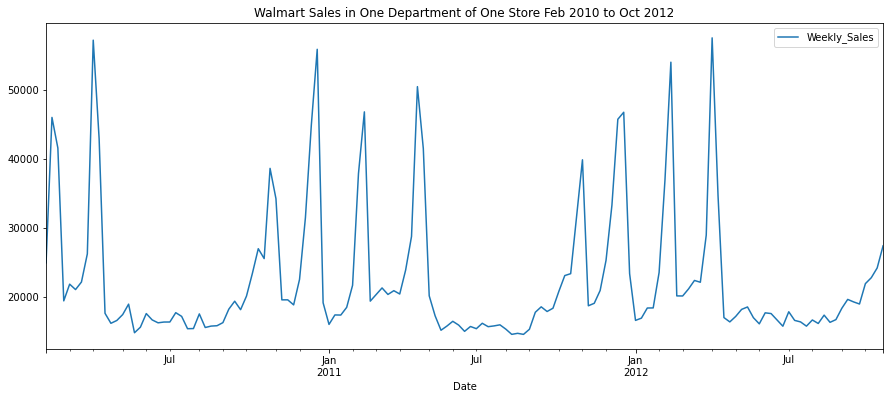

In [7]:
# Plotting
dat_grouped.plot(figsize=(15, 6), title="Walmart Sales in One Department of One Store Feb 2010 to Oct 2012")
plt.show()

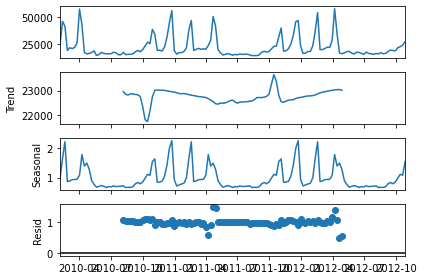

In [8]:
# Seasonal Decomposition
result = seasonal_decompose(dat_grouped, model='multiplicative')
fig = result.plot()
plt.show()

In [9]:
# ADF Test
result_adf = adfuller(dat_grouped['Weekly_Sales'])
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

ADF Statistic: -2.5221638686500403
p-value: 0.11017432282586914


In [10]:
# Log Transformation
dat_grouped['Weekly_Sales_log'] = np.log(dat_grouped['Weekly_Sales'])

In [11]:
# Calculate first differences
dat_grouped["Weekly_Sales_diff"] = dat_grouped['Weekly_Sales_log'].diff()


<AxesSubplot:xlabel='Date'>

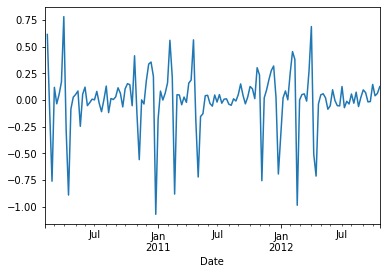

In [12]:
dat_grouped["Weekly_Sales_diff"].plot()

In [13]:
# Convert to growth rates (multiply by 100)
dat_grouped['Weekly_Sales_growth'] = dat_grouped['Weekly_Sales_diff'] * 100


In [14]:
print(dat_grouped.head())

            Weekly_Sales  Weekly_Sales_log  Weekly_Sales_diff  \
Date                                                            
2010-02-05      24924.50         10.123607                NaN   
2010-02-12      46039.49         10.737255           0.613648   
2010-02-19      41595.55         10.635748          -0.101506   
2010-02-26      19403.54          9.873211          -0.762538   
2010-03-05      21827.90          9.990944           0.117733   

            Weekly_Sales_growth  
Date                             
2010-02-05                  NaN  
2010-02-12            61.364825  
2010-02-19           -10.150632  
2010-02-26           -76.253767  
2010-03-05            11.773344  


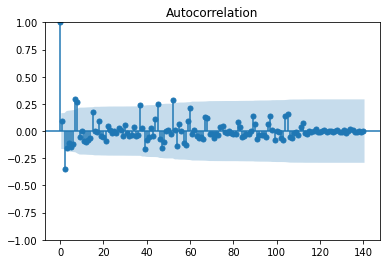

In [16]:
#acf plot
plot_acf(dat_grouped['Weekly_Sales_growth'].dropna(), lags=140)
plt.show()

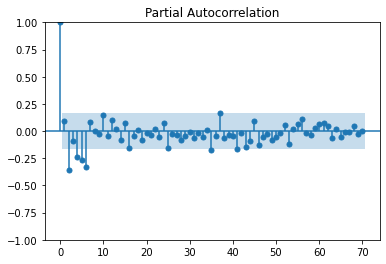

In [18]:
#pacf plot
plot_pacf(dat_grouped['Weekly_Sales_growth'].dropna(), lags=70)
plt.show()

In [ ]:
# SARIMA Model
train = dat_grouped.loc[:'2012-09-01']['Weekly_Sales']

# Use auto_arima to find optimal SARIMA parameters
sarima_model = auto_arima(train, seasonal=True, m=12, trace=True, suppress_warnings=True)

# Training the Model
sarima_model.fit(train)

In [ ]:
# Forecasting
future_forecast = sarima_model.predict(n_periods=len(dat_grouped) - len(train))
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Training')
plt.plot(dat_grouped.index, dat_grouped['Weekly_Sales'], label='Actual')
plt.plot(dat_grouped.index, np.concatenate([train.values, future_forecast]), label='Forecast')
plt.title("Walmart Sales SARIMA Prediction")
plt.legend()
plt.show()

In [ ]:
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

# Calculate MAPE for the forecasted values
mape = calculate_mape(dat_grouped['Weekly_Sales']['2012-05-02':], future_forecast)

# Print the percentage of true predictions
accuracy_percentage = 100 - mape
print(f'Accuracy Percentage: {accuracy_percentage:.2f}%')
